### TensorBoard 介绍
```
TensorBoard 是 TensorFlow 中强大的可视化工具，支持标量、文本、图像、音频、视频和 Embedding 等多种数据可视化。
在 PyTorch 中也可以使用 TensorBoard，具体是使用 TensorboardX 来调用 TensorBoard。除了安装 TensorboardX，还要安装 TensorFlow 和 TensorBoard，其中 TensorFlow 和 TensorBoard 需要一致。
TensorBoardX 可视化的流程需要首先编写 Python 代码把需要可视化的数据保存到 event file 文件中，然后再使用 TensorBoardX 读取 event file 展示到网页中。


In [40]:
# -*- coding: utf-8 -*-
"""
通用函数
"""


import torch
import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms


def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])

    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    if 'ToTensor' in str(transform_train):
        img_ = img_.detach().numpy() * 255

    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception("Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]) )

    return img_


def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)




In [41]:
# 下面的代码是一个保存 event file 的例子
import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

max_epoch = 64

writer = SummaryWriter(comment='test_comment', filename_suffix="test_suffix")

for x in range(max_epoch):
    writer.add_scalar('y=2x', x * 2, x)
    writer.add_scalar('y=pow_2_x', 2 ** x, x)
    writer.add_scalars('data/scalar_group', {"xsinx": x * np.sin(x),
                                                "xcosx": x * np.cos(x) }, x)

writer.close()

### optimizer 的属性
```python
class Optimizer(object):
    def __init__(self, params, defaults):        
        self.defaults = defaults
        self.state = defaultdict(dict)
        self.param_groups = []
```
```
主要有 3 个属性
    defaults：优化器的超参数，如 weight_decay，momentum
    state：参数的缓存，如 momentum 中需要用到前几次的梯度，就缓存在这个变量中
    param_groups：管理的参数组，是一个 list，其中每个元素是字典，包括 momentum、lr、weight_decay、params 等。
    _step_count：记录更新 次数，在学习率调整中使用
```

### SummaryWriter
```python
torch.utils.tensorboard.writer.SummaryWriter(log_dir=None, comment='', purge_step=None, max_queue=10, flush_secs=120, filename_suffix='')
```
```
功能：提供创建 event file 的高级接口
主要功能：
    log_dir：event file 输出文件夹，默认为runs文件夹
    comment：不指定 log_dir 时，runs文件夹里的子文件夹后缀
    filename_suffix：event_file 文件名后缀

In [42]:
log_dir = "./train_log/test_log_dir"
writer = SummaryWriter(log_dir=log_dir, comment='_scalars', filename_suffix="12345678")
# writer = SummaryWriter(comment='_scalars', filename_suffix="12345678")

for x in range(60):
    writer.add_scalar('y=pow_2_x', 2 ** x, x)

writer.close()

### add_scalar
```python
add_scalar(tag, scalar_value, global_step=None, walltime=None)
```
```
功能：记录标量
    tag：图像的标签名，图的唯一标识
    scalar_value：要记录的标量，y 轴的数据
    global_step：x 轴的数据

### add_scalars
```上面的add_scalar()只能记录一条曲线的数据。但是我们在实际中可能需要在一张图中同时展示多条曲线，比如在训练模型时，经常需要同时查看训练集和测试集的 loss。这时我们可以使用add_scalars()方法
```
```python
add_scalars(main_tag, tag_scalar_dict, global_step=None, walltime=None)
```
main_tag：该图的标签
tag_scalar_dict：用字典的形式记录多个曲线。key 是变量的 tag，value 是变量的值

In [43]:
from tensorboardX import SummaryWriter

max_epoch = 64
writer = SummaryWriter(comment='test_comment', filename_suffix="test_suffix")
for x in range(max_epoch):
    writer.add_scalar('y=2x', x * 2, x)
    writer.add_scalar('y=pow_2_x', 2 ** x, x)
    writer.add_scalars('data/scalar_group', {"xsinx": x * np.sin(x),
                                                "xcosx": x * np.cos(x)}, x)
writer.close()

### add_histogram
```python
add_histogram(tag, values, global_step=None, bins='tensorflow', walltime=None, max_bins=None)
```
```
功能：统计直方图与多分位折线图
    tag：图像的标签名，图的唯一标识
    values：要统计的参数，通常统计权值、偏置或者梯度
    global_step：第几个子图
    bins：取直方图的 bins

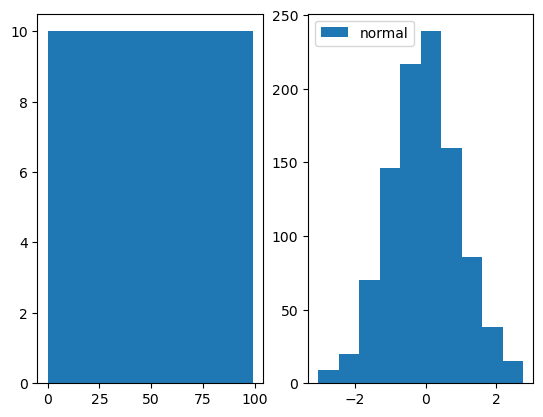

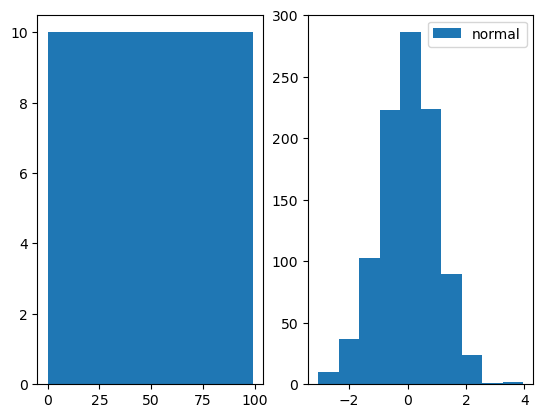

In [44]:
from tensorboardX import SummaryWriter
writer = SummaryWriter(comment='test_comment', filename_suffix="test_suffix")
for x in range(2):
    np.random.seed(x)
    data_union = np.arange(100)
    data_normal = np.random.normal(size=1000)
    writer.add_histogram('distribution union', data_union, x)
    writer.add_histogram('distribution normal', data_normal, x)
    plt.subplot(121).hist(data_union, label="union")
    plt.subplot(122).hist(data_normal, label="normal")
    plt.legend()
    plt.show()
writer.close()

### add_image
```python
add_image(tag, img_tensor, global_step=None, walltime=None, dataformats='CHW')
```
```
功能：记录图像
    tag：图像的标签名，图像的唯一标识
    img_tensor：图像数据，需要注意尺度
    global_step：记录这是第几个子图
    dataformats：数据形式，取值有'CHW'，'HWC'，'HW'。如果像素值在 [0, 1] 之间，那么默认会乘以 255，放大到 [0, 255] 范围之间。如果有大于 1 的像素值，认为已经是 [0, 255] 范围，那么就不会放大。


In [45]:
import time
from tensorboardX import SummaryWriter

writer = SummaryWriter(comment='test_your_comment', filename_suffix="_test_your_filename_suffix")

# img 1     random
# 随机噪声的图片
fake_img = torch.randn(3, 512, 512)
writer.add_image("fake_img", fake_img, 1)
time.sleep(1)

# img 2     ones
# 像素值全为 1 的图片，会乘以 255，所以是白色的图片
fake_img = torch.ones(3, 512, 512)
time.sleep(1)
writer.add_image("fake_img", fake_img, 2)

# img 3     1.1
# 像素值全为 1.1 的图片，不会乘以 255，所以是黑色的图片
fake_img = torch.ones(3, 512, 512) * 1.1
time.sleep(1)
writer.add_image("fake_img", fake_img, 3)

# img 4     HW
fake_img = torch.rand(512, 512)
writer.add_image("fake_img", fake_img, 4, dataformats="HW")

# img 5     HWC
fake_img = torch.rand(512, 512, 3)
writer.add_image("fake_img", fake_img, 5, dataformats="HWC")

writer.close()


### torchvision.utils.make_grid
```
上面虽然可以通过拖动显示每张图片，但实际中我们希望在网格中同时展示多张图片，可以用到make_grid()函数。
```
```python
torchvision.utils.make_grid(tensor: Union[torch.Tensor, List[torch.Tensor]], nrow: int = 8, padding: int = 2, normalize: bool = False, range: Optional[Tuple[int, int]] = None, scale_each: bool = False, pad_value: int = 0)
```
```
功能：制作网格图像
    tensor：图像数据，$B \times C \times H \times W$的形状
    nrow：行数(列数是自动计算的，为：$\frac{B}{nrow}$)
    padding：图像间距，单位是像素，默认为 2
    normalize：是否将像素值标准化到 [0, 255] 之间
    range：标准化范围，例如原图的像素值范围是 [-1000, 2000]，设置 range 为 [-600, 500]，那么会把小于 -600 的像素值变为 -600，那么会把大于 500 的像素值变为 500，然后标准化到 [0, 255] 之间
    scale_each：是否单张图维度标准化
    pad_value：间隔的像素值

In [46]:

# writer = SummaryWriter(comment='test_your_comment', filename_suffix="_test_your_filename_suffix")

# split_dir = os.path.join(enviroments.project_dir, "data", "rmb_split")
# train_dir = os.path.join(split_dir, "train")
# # train_dir = "path to your training data"
# # 先把宽高缩放到 [32， 64] 之间，然后使用 toTensor 把 Image 转化为 tensor，并把像素值缩放到 [0, 1] 之间
# transform_compose = transforms.Compose([transforms.Resize((32, 64)), transforms.ToTensor()])
# train_data = RMBDataset(data_dir=train_dir, transform=transform_compose)
# train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
# data_batch, label_batch = next(iter(train_loader))

# img_grid = vutils.make_grid(data_batch, nrow=4, normalize=True, scale_each=True)
# # img_grid = vutils.make_grid(data_batch, nrow=4, normalize=False, scale_each=False)
# writer.add_image("input img", img_grid, 0)

# writer.close()

### AlexNet 卷积核与特征图可视化

```
用 TensorBoard 可视化 AlexNet 网络的前两层卷积核。其中每一层的卷积核都把输出的维度作为 global_step，包括两种可视化方式：一种是每个 (w, h) 维度作为灰度图，添加一个 c 的维度，形成 (b, c, h, w)，其中 b 是 输入的维度；另一种是把整个卷积核 reshape 到 c 是 3 的形状，再进行可视化。

In [47]:

# writer = SummaryWriter(comment='test_your_comment', filename_suffix="_test_your_filename_suffix")

# alexnet = models.alexnet(pretrained=True)

# # 当前遍历到第几层网络的卷积核了
# kernel_num = -1
# # 最多显示两层网络的卷积核:第 0 层和第 1 层
# vis_max = 1

# # 获取网络的每一层
# for sub_module in alexnet.modules():
#     # 判断这一层是否为 2 维卷积层
#     if isinstance(sub_module, nn.Conv2d):
#         kernel_num += 1
#         # 如果当前层大于1，则停止记录权值
#         if kernel_num > vis_max:
#             break
#         # 获取这一层的权值
#         kernels = sub_module.weight
#         # 权值的形状是 [c_out, c_int, k_w, k_h]
#         c_out, c_int, k_w, k_h = tuple(kernels.shape)

#         # 根据输出的每个维度进行可视化
#         for o_idx in range(c_out):
#             # 取出的数据形状是 (c_int, k_w, k_h)，对应 BHW; 需要扩展为 (c_int, 1, k_w, k_h)，对应 BCHW
#             kernel_idx = kernels[o_idx, :, :, :].unsqueeze(1)   # make_grid需要 BCHW，这里拓展C维度
#             # 注意 nrow 设置为 c_int，所以行数为 1。在 for 循环中每 添加一个，就会多一个 global_step
#             kernel_grid = vutils.make_grid(kernel_idx, normalize=True, scale_each=True, nrow=c_int)
#             writer.add_image('{}_Convlayer_split_in_channel'.format(kernel_num), kernel_grid, global_step=o_idx)
#         # 因为 channe 为 3 时才能进行可视化，所以这里 reshape
#         kernel_all = kernels.view(-1, 3, k_h, k_w)  #b, 3, h, w
#         kernel_grid = vutils.make_grid(kernel_all, normalize=True, scale_each=True, nrow=8)  # c, h, w
#         writer.add_image('{}_all'.format(kernel_num), kernel_grid, global_step=kernel_num+1)

#         print("{}_convlayer shape:{}".format(kernel_num, tuple(kernels.shape)))

# writer.close()

```
下面把 AlexNet 的第一个卷积层的输出进行可视化，首先对图片数据进行预处理(resize，标准化等操作)。由于在定义模型时，网络层通过nn.Sequential() 堆叠，保存在 features 变量中。因此通过 features 获取第一个卷积层。把图片输入卷积层得到输出，形状为 (1, 64, 55, 55)，需要转换为 (64, 1, 55, 55)，对应 (B, C, H, W)，nrow 设置为 8，最后进行可视化，代码如下：

In [48]:
# writer = SummaryWriter(comment='test_your_comment', filename_suffix="_test_your_filename_suffix")

# # 数据
# path_img = "image/lena.png"     # your path to image
# normMean = [0.49139968, 0.48215827, 0.44653124]
# normStd = [0.24703233, 0.24348505, 0.26158768]

# norm_transform = transforms.Normalize(normMean, normStd)
# img_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     norm_transform
# ])

# img_pil = Image.open(path_img).convert('RGB')
# if img_transforms is not None:
#     img_tensor = img_transforms(img_pil)
# img_tensor.unsqueeze_(0)    # chw --> bchw

# # 模型
# alexnet = models.alexnet(pretrained=True)

# # forward
# # 由于在定义模型时，网络层通过nn.Sequential() 堆叠，保存在 features 变量中。因此通过 features 获取第一个卷积层
# convlayer1 = alexnet.features[0]
# # 把图片输入第一个卷积层
# fmap_1 = convlayer1(img_tensor)

# # 预处理
# fmap_1.transpose_(0, 1)  # bchw=(1, 64, 55, 55) --> (64, 1, 55, 55)
# fmap_1_grid = vutils.make_grid(fmap_1, normalize=True, scale_each=True, nrow=8)

# writer.add_image('feature map in conv1', fmap_1_grid, global_step=322)
# writer.close()

### add_graph
```python
add_graph(model, input_to_model=None, verbose=False)
```
```
功能：可视化模型计算图
    model：模型，必须继承自 nn.Module
    input_to_model：输入给模型的数据，形状为 BCHW
    verbose：是否打印图结构信息
```

In [49]:
import os
import random
import shutil
import torch
from PIL import Image

import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import torchvision.transforms as transforms

from tensorboardX import  SummaryWriter
import matplotlib.pyplot as plt

class LeNet(nn.Module):
    # 子模块创建
    def __init__(self, classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, classes)

    # 子模块拼接
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0, 0.1)
                m.bias.data.zero_()


class LeNetSequetial(nn.Module):
    def __init__(self, classes):
        super(LeNetSequetial, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0, 0.1)
                m.bias.data.zero_()

In [50]:
writer = SummaryWriter(comment='test_your_comment', filename_suffix="_test_your_filename_suffix")

# 模型
fake_img = torch.randn(1, 3, 32, 32)
lenet = LeNet(classes=2)
writer.add_graph(lenet, fake_img)
writer.close()

### torchsummary
```
模型计算图的可视化还是比较复杂，不够清晰。而torchsummary能够查看模型的输入和输出的形状，可以更加清楚地输出模型的结构。
```
```python
torchsummary.summary(model, input_size, batch_size=-1, device="cuda")
```
```
功能：查看模型的信息，便于调试
    model：pytorch 模型，必须继承自 nn.Module
    input_size：模型输入 size，形状为 CHW
    batch_size：batch_size，默认为 -1，在展示模型每层输出的形状时显示的 batch_size
    device："cuda"或者"cpu"

In [53]:
from torchsummary import summary
# 模型
lenet = LeNet(classes=2)
print(summary(lenet, (3, 32, 32), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                    [-1, 2]             170
Total params: 61,326
Trainable params: 61,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.23
Estimated Total Size (MB): 0.30
----------------------------------------------------------------
None
